In [1]:
# July 2023
# Implementing VoxNet for Autoencoder (not classification that explained previously):


In [2]:
# VoxnetEncoder is a name I myself selected here. I'm not sure if there is something similar out
# there for this or not...

In [3]:
# I'm using the architecture at 
# https://github.com/kdj842969/3D-Autoencoder/blob/master/train.py#L35


# 1) Voxeling Modelnet10

In [4]:
dataset_addr = '/home/sbn/Downloads/datasets/data_/ModelNet10/'

In [5]:
import torch
from torch.utils.data import DataLoader
import numpy as np




# import sys
# sys.path.insert(0, dataset_addr)
from modelnet10 import ModelNet10

CLASSES = {
    0: 'bathtub',
    1: 'chair',
    2: 'dresser',
    3: 'night_stand',
    4: 'sofa',
    5: 'toilet',
    6: 'bed',
    7: 'desk',
    8: 'monitor',
    9: 'table'
}
N_CLASSES = len(CLASSES)



train_dataset = ModelNet10(data_root= dataset_addr, 
                           n_classes=N_CLASSES, 
                           idx2cls=CLASSES, 
                           split='train')

train_dataloader = DataLoader(train_dataset, 
                              batch_size=1, 
                              shuffle=True)




{'bathtub': 0, 'chair': 1, 'dresser': 2, 'night_stand': 3, 'sofa': 4, 'toilet': 5, 'bed': 6, 'desk': 7, 'monitor': 8, 'table': 9}


# Testing voxel

In [6]:
for sample in train_dataloader:
    voxel, cls_idx = sample['voxel'], sample['cls_idx']
    print(voxel.shape)
    break

torch.Size([1, 1, 32, 32, 32])


# VoxNet Encoder/ Decoder

<!-- ![image](images/VoxNet.png) -->

In [7]:
from torchsummary import summary


In [8]:
import torch
from torch import nn

In [9]:
class BinaryActication(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z):
        
        ctx.save_for_backward(z) # saves z in y=f(z). z is an array for all output neurons.
        y = z.clone()
        y[(y>=0)] = 1
        y[(y!=1)] = 0
#         y = torch.sign(z)        # y shows y in y=f(z). Here just I know the size is like z'size.              
        return y
    
    @staticmethod
    def backward(ctx, grad_output):
        z, = ctx.saved_tensors
        dy_dz = z.clone()
        dy_dz[(dy_dz>=-1) * (dy_dz<=1)] = 1
        dy_dz[(dy_dz!=1)] = 0
        # print('dy/dz=', dy_dz)
        return  dy_dz

In [10]:
torch.sign(torch.tensor([0.01, 0.1,-0.4,-1.2]))

tensor([ 1.,  1., -1., -1.])

In [11]:
# note:
# Exactly copying the architecture from 
# https://github.com/kdj842969/3D-Autoencoder/blob/master/train.py#L35

class VoxNetAutoencoder(nn.Module):
    def __init__(self):
        super(VoxNetAutoencoder, self).__init__()
        self.VoxNetEncoder = nn.Sequential(
                nn.Conv3d(in_channels=1, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
#                 nn.BatchNorm3d(30),
               
    
                nn.Conv3d(in_channels=30, out_channels=60, kernel_size=(5,5,5), stride=1,  padding=2, padding_mode='replicate'),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
                
#                 nn.Conv3d(in_channels=60, out_channels=30, kernel_size=(3,3,3), stride=1,  padding=1),
#                 nn.ReLU(),

#                 nn.BatchNorm3d(60),
#                 nn.ReLU()
        )
        
        self.VoxNetDecoder = nn.Sequential(
                nn.Conv3d(in_channels=60, out_channels=60, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
                nn.ReLU(),

                nn.Upsample(scale_factor=2.06),        

                
                nn.Conv3d(in_channels=60, out_channels=60, kernel_size=(3,3,3), stride=1, padding=1, padding_mode='replicate'),
#                 nn.BatchNorm3d(16),
                nn.ReLU(),
            
                nn.Upsample(scale_factor=2.06),
#                 nn.BatchNorm3d(16),
            
                nn.Conv3d(in_channels=60, out_channels=1, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'),
                nn.ReLU()

                
        )
        

                
    def forward(self, x):
        x = self.VoxNetEncoder(x)
        x = self.VoxNetDecoder(x)
#         return BinaryActication.apply(x) 
        return x
#         r
#         return 
        

In [12]:


class VoxNetAutoencoder(nn.Module):
    def __init__(self):
        super(VoxNetAutoencoder, self).__init__()
        self.VoxNetEncoder = nn.Sequential(
                nn.Conv3d(in_channels=1, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
                nn.BatchNorm3d(30), 
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
#                 nn.BatchNorm3d(30),
               
                
    
                nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1,  padding=2, padding_mode='replicate'),
                nn.BatchNorm3d(30),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
                nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
            
            
                nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1,  padding=2, padding_mode='replicate'),
                nn.BatchNorm3d(30),
                nn.LeakyReLU(),
                nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
            
            
#                 nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1,  padding=2, padding_mode='replicate'),
#                 nn.BatchNorm3d(30),
#                 nn.ReLU(),
#                 nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
            
            
#                 nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1,  padding=2, padding_mode='replicate'),
# #                 nn.BatchNorm3d(30),
#                 nn.ReLU(),
#                 nn.MaxPool3d(kernel_size=(2,2,2), stride=2),
                
#                 nn.Conv3d(in_channels=60, out_channels=30, kernel_size=(3,3,3), stride=1,  padding=1),
#                 nn.ReLU(),

#                 nn.BatchNorm3d(60),
#                 nn.ReLU()
        )
        
        self.VoxNetDecoder = nn.Sequential(

#                 nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
# #                 nn.BatchNorm3d(30),
#             nn.ReLU(),
#                 nn.Upsample(scale_factor=2.06), 
            
#                 nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
#                 nn.BatchNorm3d(30),
#             nn.LeakyReLU(),
#                 nn.Upsample(scale_factor=2.06), 
            
                nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
                nn.BatchNorm3d(30),
            nn.LeakyReLU(),
                nn.Upsample(scale_factor=2.06), 
            
                nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'), 
                nn.BatchNorm3d(30),
            nn.LeakyReLU(),
                nn.Upsample(scale_factor=2.06),        

                
                nn.Conv3d(in_channels=30, out_channels=30, kernel_size=(3,3,3), stride=1, padding=1, padding_mode='replicate'),
#                 nn.BatchNorm3d(16),
                nn.BatchNorm3d(30),
            nn.LeakyReLU(),
            
                nn.Upsample(scale_factor=2.06),
#                 nn.BatchNorm3d(16),
            
                nn.Conv3d(in_channels=30, out_channels=1, kernel_size=(5,5,5), stride=1, padding=2, padding_mode='replicate'),
                nn.LeakyReLU()

                
        )
        

                
    def forward(self, x):
        x = self.VoxNetEncoder(x)
        x = self.VoxNetDecoder(x)
#         return BinaryActication.apply(x) 
        return x
#         r
#         return 

In [13]:
model = VoxNetAutoencoder()

In [14]:
from torchsummary import summary

In [15]:
# the input size is = (5,1, 32,32,32), in which 5 is batch_size, 1 = channel. 
summary(model, (1,32,32,32), batch_size=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [5, 30, 32, 32, 32]           3,780
       BatchNorm3d-2        [5, 30, 32, 32, 32]              60
         LeakyReLU-3        [5, 30, 32, 32, 32]               0
           Dropout-4        [5, 30, 32, 32, 32]               0
         MaxPool3d-5        [5, 30, 16, 16, 16]               0
            Conv3d-6        [5, 30, 16, 16, 16]         112,530
       BatchNorm3d-7        [5, 30, 16, 16, 16]              60
         LeakyReLU-8        [5, 30, 16, 16, 16]               0
           Dropout-9        [5, 30, 16, 16, 16]               0
        MaxPool3d-10           [5, 30, 8, 8, 8]               0
           Conv3d-11           [5, 30, 8, 8, 8]         112,530
      BatchNorm3d-12           [5, 30, 8, 8, 8]              60
        LeakyReLU-13           [5, 30, 8, 8, 8]               0
        MaxPool3d-14           [5, 30, 

In [16]:
voxel.shape

torch.Size([1, 1, 32, 32, 32])

In [17]:
model = VoxNetAutoencoder()


In [18]:
model(voxel.float()).shape

torch.Size([1, 1, 32, 32, 32])

In [19]:
a = torch.tensor([0.1])
loss = nn.BCELoss()
loss(a,a)

tensor(0.3251)

In [20]:
# these are the same as nn.BCELoss()
# torch.nn.functional.binary_cross_entropy(a,a)

In [21]:
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.003)

In [22]:
loss = nn.MSELoss()
loss = nn.BCELoss()
# loss = nn.functional.binary_cross_entropy_with_logits(a, a)
loss

BCELoss()

In [26]:
print("Start training ...")
model.train()

for epoch in range(30):
    overall_loss = 0
    for batch_idx, sample in enumerate(train_dataloader):
        x,y =  sample['voxel'], sample['cls_idx']
        
        optimizer.zero_grad()
        y_hat = model(x.float()).float()
#         ll = loss(y_hat, x.float())
        ll = nn.functional.binary_cross_entropy_with_logits(y_hat, x.float())
        if (batch_idx%2==0):
            print(ll)
        overall_loss += ll.item()
        ll.backward()
        optimizer.step()
        
#         break
        
#     print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    print(overall_loss)
    
print("Finish!!")

Start training ...
tensor(0.6919, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6928, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6903, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6901, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6900, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6902, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6900, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6900, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6916, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6899, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6907, grad_f

tensor(0.6821, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6841, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6911, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6834, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6825, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6822, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6820, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6824, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6893, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6822, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6832, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6813, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6847, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6814, grad_fn=<BinaryCrossEntro

tensor(0.6774, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6740, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6749, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6741, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6744, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6739, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6741, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6780, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6729, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6806, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6764, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6731, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6739, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6746, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6751, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6742, grad_fn=<BinaryCrossEntro

tensor(0.6674, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6684, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6640, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6638, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6676, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6672, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6642, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6684, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6810, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6719, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6641, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6704, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6666, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6644, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6663, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6634, grad_fn=<BinaryCrossEntro

tensor(0.6671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6581, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6591, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6618, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6568, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6604, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6559, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6580, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6562, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6616, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6592, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6584, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6551, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6552, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6582, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6535, grad_fn=<BinaryCrossEntro

tensor(0.6468, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6466, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6648, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6497, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6494, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6514, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6468, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6452, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6508, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6469, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6445, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6454, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6500, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6461, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6457, grad_fn=<BinaryCrossEntro

KeyboardInterrupt: 

# Test Sample:

In [65]:
model.eval()

print('Test Sample:')
for sample in train_dataloader:
    sample_x, sample_y = sample['voxel'], sample['cls_idx']
#     sample_y_hat = torch.argmax(
#     bottle_neck = model.VoxNetEncoder(sample_x.float())
#     print(bottle_neck)
    print('Ground Truth  =', sample_y, 'class=', CLASSES[sample_y.item()])
#     print('Predicted     =', sample_y_hat)
#     print(voxel.shape)
    
    reconstructed_sample = model(sample_x.float()).reshape(32,32,32)
    sample = np.empty((1,3))
    for i in range(32):
        for j in range(32):
            for k in range(32):
#                 if reconstructed_sample[i][j][k]>0:
#                     print(reconstructed_sample[i][j][k])
                if (reconstructed_sample[i][j][k]>-0.08):
                    reconstructed_sample[i][j][k]= 1
                    sample = np.vstack((sample, np.array([i,j,k])))
                else:
                    reconstructed_sample[i][j][k] = 0
                    
#                 print(i,j,k,': ', reconstructed_sample[i][j][k] )
    break
# print(sample.shape)    
print(reconstructed_sample.shape)
np.savetxt('sample.xyz',sample)    

Test Sample:
Ground Truth  = tensor([9]) class= table
torch.Size([32, 32, 32])


## Visualization

In [45]:
# The code is coppied from:
# https://github.com/kdj842969/3D-Autoencoder/blob/master/test_vis.py

<Figure size 640x480 with 0 Axes>

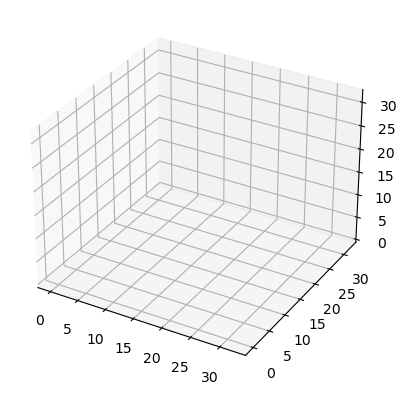

In [46]:


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import os

output_path = "./"
num_img = 10
voxels = reconstructed_sample
x, y, z = np.indices((32, 32, 32))
fig = plt.figure()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.voxels(voxels, facecolors='#5DADE2', edgecolors='#34495E')
filename = 'demo.png'
path = os.path.join(output_path, filename)
plt.savefig(path)

In [ ]:
# Saving VoxNet model and its parameters.
torch.save(model.state_dict(), "model/AutoEncoderVoxNetmodel.params")
torch.save(model.state_dict(), "model/AutoEncoderVoxNetmodel.params.pt")
torch.save(model, "model/enitre_AutoEncoderVoxNetmodell")

In [ ]:
#  (Uncomment this if you want):
# # Whenever it's needed you can do loading the trained model with*:
# model = torch.load("model/enitre_VoxNetmodel")
# model.eval()

In [ ]:
# print('Test Sample:')
# for sample in train_dataloader:
#     sample_x, sample_y = sample['voxel'], sample['cls_idx']
#     sample_y_hat = torch.argmax(model(sample_x.float()))
#     print('Ground Truth  =', sample_y)
#     print('Predicted     =', sample_y_hat)
# #     print(voxel.shape)
#     break

In [ ]:
# commnets
# This autoencoder (here) and voxnet (classification model in the last notebook) are so slow, as they 
# need high compuataion. In the referenced work, epoch=20 which is not working
# fast on my machine here. 
# If you are intetested, read VOLO model by the name: 
# "Convolutional Neural Network for 3D Object Recognition using Volumetric representation", Xiaofan Xu
# They intrdoduced a 3d to 2d approch for accelerating this.
# Skip Connection